# Datenanalyse            <img align="right" width=430 src="https://www.btelligent.com/fileadmin/_processed_/7/0/csm_data-science-ansatz_2350412d17.jpg" style="max-width:20%">
Mit diesem Notebook wollen wir die ermittelten räumlichen Daten hinsichtlich ihrer statistischen Zusammenhänge analysieren und Einflussfaktoren auf die UFP-Konzentrationen in Adlershof identifizieren.

>***Beachtet:*** Es handelt sich hierbei um echte Messdaten mit allen ihren Eigenheiten und kein aufpolierten Beispieldatensatz. Wir sind der Meinung, dass der Mehrwert solcher Daten in der Übung größer ist, da sie denen, die ihr erheben werdet ähnlicher sind. Nicht alle gezeigten Verfahren sind bei diesem Datensatz zielführend. Das Notebook zielt darauf ab, euch eine **Palette an Werkzeugen** zu bieten, die ihr für eure eigenen Auswertung einsetzen könnt.

Zunächst importieren wir wieder die nötigen Pakete, definieren unseren Pfad (bzw. den Dateinnamen wenn im selben Ordner) und laden die CSV-Datei als Pandas-Dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
import seaborn as sbn
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

path = "your_qgis_output.csv"

data = pd.read_csv(path, sep = ",")
print(data.head())

   distance  Concentrat strassenkl    dtvw_kfz_m  dtvw_lkw_m    traff_mean
0        50      6881.5        III  13533.333333       630.0  18573.333333
1       150      7169.5        III  14250.000000       662.5  19550.000000
2       250      6451.5        III  15000.000000       650.0  20200.000000
3       350      6901.5        III  15000.000000       650.0  20200.000000
4       450      5906.0        III  15150.000000       520.0  19310.000000


# Korrelationsanalyse <img align="right" width="500" src="https://kulturdata.de/wp-content/uploads/2017/07/Nicolas-Cage-809x319.jpeg" style="max-width:100%">

Zunächst benennen wir die Spalten neu, um Missverständnisse zu vermeiden. **Solltet ihr von meiner Reihenfolge und Benennung abgewichen sein, passt die Benennung hier bitte an.**

In [2]:
data.columns = ['trackpoint', 'ufp', 'street_class', 'kfz', 'lkw', 'tot_traffic']
data.set_index("trackpoint", inplace=True)
print(data.head())

               ufp street_class           kfz    lkw   tot_traffic
trackpoint                                                        
50          6881.5          III  13533.333333  630.0  18573.333333
150         7169.5          III  14250.000000  662.5  19550.000000
250         6451.5          III  15000.000000  650.0  20200.000000
350         6901.5          III  15000.000000  650.0  20200.000000
450         5906.0          III  15150.000000  520.0  19310.000000


Der Datensatz enthält noch ziemlich viele `NaN`, da wir ja nur für knapp die Hälfte der Messpunkte Verkehrsdaten haben. Für die Analysen müssen wir diese Werte entfernen.
Zunächst nutzen wir Boolean Indexing, um alle Zeilen zu markieren, in denen es keine UFP-Daten gibt (also wo `isna() = True` gilt).

In [3]:
where_nan = data['ufp'].isna()
print(where_nan)

trackpoint
50       False
150      False
250      False
350      False
450      False
         ...  
45050    False
45150    False
45250    False
45350    False
45450    False
Name: ufp, Length: 454, dtype: bool


Nun erstellen wir ein Subset der Datentabelle, in der alle Zeilen UFP-Daten haben. Die `~` kehrt den Boolean Index dabei um: `NaN = False`. Da wir die vollständigen Daten nicht mehr brauchen überschreiben wir die Originaltabelle mit dem Subset (*von 454 auf 436 Zeilen*).

In [4]:
data = data[~where_nan]
print(data)

                ufp street_class           kfz         lkw   tot_traffic
trackpoint                                                              
50           6881.5          III  13533.333333  630.000000  18573.333333
150          7169.5          III  14250.000000  662.500000  19550.000000
250          6451.5          III  15000.000000  650.000000  20200.000000
350          6901.5          III  15000.000000  650.000000  20200.000000
450          5906.0          III  15150.000000  520.000000  19310.000000
...             ...          ...           ...         ...           ...
45050        7275.0          III  13500.000000  510.000000  17580.000000
45150        6101.0            V  14466.666667  593.333333  19213.333333
45250       17187.0          III  14950.000000  675.000000  20350.000000
45350       28066.0          III  14250.000000  662.500000  19550.000000
45450        7064.0          III  14250.000000  662.500000  19550.000000

[436 rows x 5 columns]


Für die verkehrsbezogenen Untersuchungen erstellen wir zudem ein Subset in dem alle Zeilen Verkehrsdaten beinhalten (*von 436 auf 211 Zeilen!*).

>**Beachte:** *Wir dürfen wir die Werte nicht 0 setzen! Dies würde bedeuten wir gehen überall, wo es keine Zählungen gab von keinem Verkehr aus.*

In [5]:
traffic_subset = data[~data['tot_traffic'].isna()]
data['street_class'].fillna('No_street', inplace=True)
print(traffic_subset)

                ufp street_class           kfz         lkw   tot_traffic
trackpoint                                                              
50           6881.5          III  13533.333333  630.000000  18573.333333
150          7169.5          III  14250.000000  662.500000  19550.000000
250          6451.5          III  15000.000000  650.000000  20200.000000
350          6901.5          III  15000.000000  650.000000  20200.000000
450          5906.0          III  15150.000000  520.000000  19310.000000
...             ...          ...           ...         ...           ...
45050        7275.0          III  13500.000000  510.000000  17580.000000
45150        6101.0            V  14466.666667  593.333333  19213.333333
45250       17187.0          III  14950.000000  675.000000  20350.000000
45350       28066.0          III  14250.000000  662.500000  19550.000000
45450        7064.0          III  14250.000000  662.500000  19550.000000

[211 rows x 5 columns]


Die naheliegendste Untersuchung ist meist die Daten hinsichtlich eines linearen Zusammenhangs zu testen. Hierfür habt ihr im ersten Semester den **Korrelationskoeffizient nach Pearson** kennen gelernt.

In [6]:
corr_traff = pearsonr(traffic_subset['tot_traffic'], traffic_subset['ufp'])    # Pearson nimmt normalverteilte Daten an!
print("------ Pearson's Korrelationskoeffizient -----")
print('r = %.3f      p = %.3E' % (corr_traff[0], corr_traff[1]))
print("\n")

------ Pearson's Korrelationskoeffizient -----
r = 0.437      p = 3.126E-11




Der Test deutet also auf einen signifikanten mittleren Zusammenhang der UFP-Konzentrationen mit dem korrigierten Verkehrsaufkommen hin.

Per Kreuzkorrelation kann man sogar alle numerischen Variablen mit nur einer Funktion auf einmal testen.

In [7]:
data.corr()

,ufp,kfz,lkw,tot_traffic
ufp,1.000000,0.445772,0.413716,0.436597
kfz,0.445772,1.000000,0.963089,0.993834
lkw,0.413716,0.963089,1.000000,0.986997
tot_traffic,0.436597,0.993834,0.986997,1.000000


Die Einfachheit dieser Funktionen verleitet jedoch dazu, die darunterliegende Datengrundlage und deren Eigenschaften zu vernachlässigen.
**Welche Bedingungen müssen für die Pearson Produkt-Moment-Korrelation erfüllt sein?**

## Verteilungen metrisch skalierter Daten

Zunächst sehen wir uns noch einmal die absolute Häufigkeitsverteilung an. Sind die Daten normalverteilt?

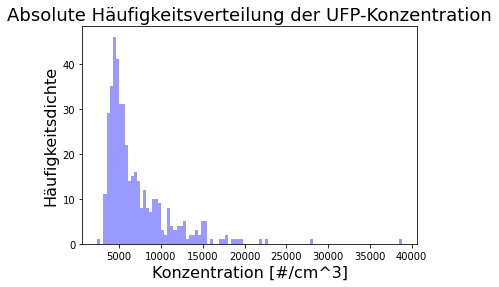

In [8]:
sbn.distplot(data['ufp'], kde=False, color='blue', bins=100)
plt.title('Absolute Häufigkeitsverteilung der UFP-Konzentration', fontsize=18)
plt.xlabel('Konzentration [#/cm^3]', fontsize=16)
plt.ylabel('Häufigkeitsdichte', fontsize=16)
plt.show()

Um Gewissheit zu bekommen, plotten wir die relative Häufigkeitsverteilung und fügen die Verteilungskurve eines Dummy-Datensatzes mit idealer Normalverteilung ein.

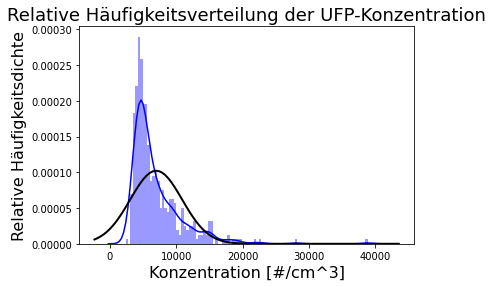

In [9]:
sbn.distplot(data['ufp'], color='blue', bins=100)
plt.title('Relative Häufigkeitsverteilung der UFP-Konzentration', fontsize=18)
plt.xlabel('Konzentration [#/cm^3]', fontsize=16)
plt.ylabel('Relative Häufigkeitsdichte', fontsize=16)

mu, std = norm.fit(data['ufp'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

Eine weitere Möglichkeit zur Einschätzung ist QQ-Plot, der die Quantile der Stichprobe gegen die einer idealen Normalverteilung aufträgt.

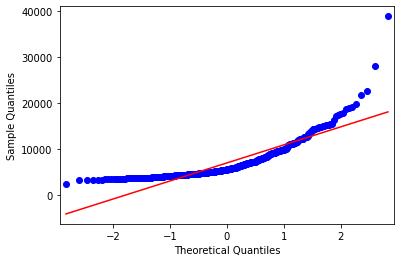

In [10]:
qqplot(data['ufp'], line='s')
plt.show()

Auch hier weicht die Verteilung deutlich vom Ideal ab. Doch nicht nur die Zieldaten sind nicht normalverteilt. Auch unsere kontinuierlichen Prädiktoren zeigen eine andere Verteilung.

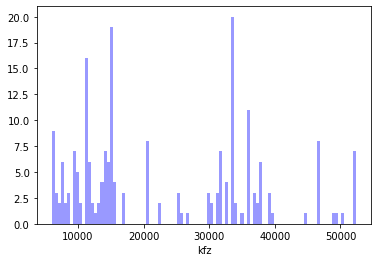

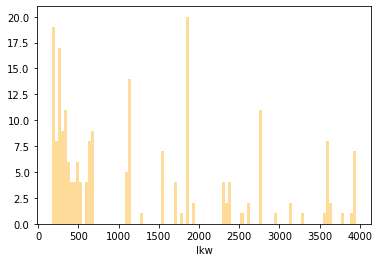

In [11]:
sbn.distplot(data['kfz'], kde=False, color='blue', bins=100)
plt.show()

sbn.distplot(data['lkw'], kde=False, color='orange', bins=100)
plt.show()

/usr/lib/python3/dist-packages/seaborn/relational.py:955: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


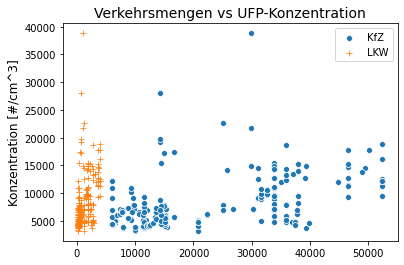

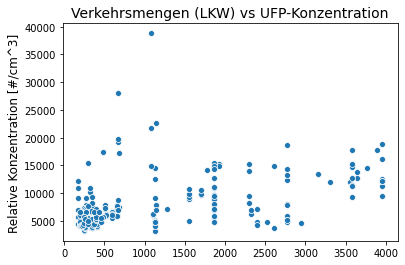

In [12]:
sbn.scatterplot('kfz', 'ufp', data=data)
sbn.scatterplot('lkw', 'ufp', data=data, marker="+")
plt.legend(labels=["KfZ", "LKW"])
plt.title('Verkehrsmengen vs UFP-Konzentration', fontsize=14)
plt.ylabel('Konzentration [#/cm^3]', fontsize=12)
plt.xlabel('')
plt.show()

sbn.scatterplot('lkw', 'ufp', data=data)
plt.title('Verkehrsmengen (LKW) vs UFP-Konzentration', fontsize=14)
plt.ylabel('Relative Konzentration [#/cm^3]', fontsize=12)
plt.xlabel('')
plt.show()

Weitere Möglichkeiten auf Normalverteilung zu untersuchen:
- Berechnung der Schiefe: `scipy.stats.skew()`
- D'Agostino test: `scipy.stats.normaltest()`
- oder viele weitere Tests ...

## Verteilungen ordinal skalierter Daten
Im Gegensatz zu den metrisch skalierten Variablen erfordern die ordinalen Straßenklassen eine andere Handhabung.
Zunächst erstellen wir eine Kopie, welche wir gemäß der Hierarchie der Straßenkategorien ordnen.

In [13]:
street_classes = ["No_street", "I", "II", "III", "IV", "V"]
data['street_class'] = pd.Categorical(data['street_class'], categories= street_classes)
data_ordered = data.sort_values(by="street_class")

Nun plotten wir zunächst kategorische Scatter...

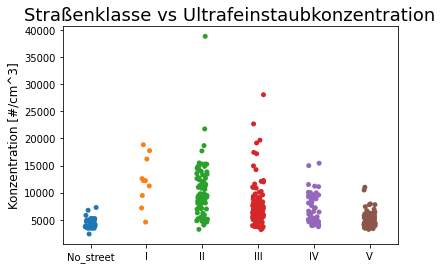

In [14]:
sbn.stripplot('street_class', 'ufp', data=data_ordered)
plt.title('Straßenklasse vs Ultrafeinstaubkonzentration', fontsize=18)
plt.ylabel('Konzentration [#/cm^3]', fontsize=12)
plt.xlabel('')
plt.show()

... und dann sogenannte Violinen-Plots. Die Form der "Violinen" zeigt dabei die Verteilungsdichte, während die Fläche die Menge der Werte in dieser Kategorie darstellt (`scale='count'`).

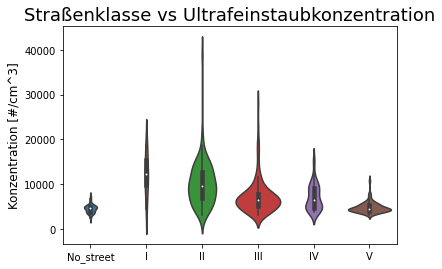

In [15]:
sbn.violinplot('street_class', 'ufp', data=data_ordered, scale="count")
plt.title('Straßenklasse vs Ultrafeinstaubkonzentration', fontsize=18)
plt.ylabel('Konzentration [#/cm^3]', fontsize=12)
plt.xlabel('')
plt.show()

**Was fällt euch auf?**

## Nicht-lineare Korrelationen
Im Gegensatz zum Pearson-Koeffizienten bieten die **Rangkorrelationen nach Spearman** (ρ) bzw. **Kendall** (τ) die Möglichkeit nicht-lineare Korrelationen zu untersuchen.
Hierfür definieren wir uns zunächst eine eigene Funktion `corr_check()`:

In [16]:
def corr_check(x, y, significance=0.05, method="spearman"):
    if method == "spearman":
        coeff, pvalue = spearmanr(x, y)
        print("------ Spearman's Rangkorrelationskoeffizient (rho) -----")
        print('ρ = %.3f' % coeff)
    elif method == "kendalltau":
        coeff, pvalue = kendalltau(x, y)
        print("------ Kendall's Rangkorrelationskoeffizient (tau) -----")
        print('τ = %.3f' % coeff)

    if pvalue > significance:
        print('Stichproben korrelieren nicht mit p=%.3E' % pvalue)
    else:
        print('Stichproben korrelieren mit p=%.3E' % pvalue)
    print("\n")

Spearman's Rangkorrelation ist weiter verbreitet aber im Vergleich etwas sensitiver gegenüber Fehlern und Ausreißern in den Daten.

In [17]:
corr_check(traffic_subset['tot_traffic'], traffic_subset['ufp'])

------ Spearman's Rangkorrelationskoeffizient (rho) -----
ρ = 0.503
Stichproben korrelieren mit p=6.057E-15




Kendall's tau fällt in der Regel niedriger aus und ist weniger sensitiv.

In [18]:
corr_check(traffic_subset['tot_traffic'], traffic_subset['ufp'], method="kendalltau")    # Kendall's tau correlation (unempfindlicher)

------ Kendall's Rangkorrelationskoeffizient (tau) -----
τ = 0.350
Stichproben korrelieren mit p=7.942E-14




Aufgrund des Einsatzes von Rängen und damit der faktischen Umwandlung von metrischen in ordinale Daten, können die beiden Verfahren auch für die kategorischen Straßenklassen angewendet werden.

In [19]:
corr_check(data['street_class'], data['ufp'])
corr_check(data['street_class'], data['ufp'], method='kendalltau')

------ Spearman's Rangkorrelationskoeffizient (rho) -----
ρ = -0.572
Stichproben korrelieren mit p=2.819E-39


------ Kendall's Rangkorrelationskoeffizient (tau) -----
τ = -0.435
Stichproben korrelieren mit p=9.364E-35




# Regression            <img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/200px-Scikit_learn_logo_small.svg.png" style="max-width:100%">
Die folgenden Zeilen zeigen euch, wie ihr in Python mit den Paketen `scikit-learn` und `matplotlib` eine Regression durchführt. Wie schon bei der Korrelationsanalyse gibt es eine Reihe von Bedingungen, die die Aussagekraft der Verfahren maßgeblich beeinflusst (vgl. Einführung in die Statistik). Nicht bei allen Verfahren sind die Bedingungen hier gegeben aber ihr könnt sie dennoch einmal ausprobieren.

Ein Blick auf die Spaltennamen gibt uns einen Überblick, welche Variablen wir miteinander vergleichen können.

In [20]:
print(data.columns.values)

['ufp' 'street_class' 'kfz' 'lkw' 'tot_traffic']


Der gemessene Ultrafeinstaubwert (`'ufp'`) wird also jeweils unsere abhängige Variable (oder "Predictand", `Y`) sein, das Verkehrsaufkommen bzw. die Straßenklasse die unabhängigen Variablen (oder "Predictor", `X`). Wir schaffen wir hierfür eine Variable (`predictor`) und führen jedes Verfahren einmal durch. Weitere Variablen untersucht ihr selbstständig durch Ändern dieser Variable.

## Univariate lineare Regression
Wir beginnen mit nur einem Prädiktor.

In [21]:
predictor = 'kfz'

Für die Regressions-Funktionen müssen wir die zu untersuchenden Spalten in NumPy-Arrays umwandeln.

In [22]:
feature = traffic_subset[[predictor]].to_numpy()
result = traffic_subset[['ufp']].to_numpy()

Im nächsten Schritt instanzieren wir die Datenklasse `LinearRegression`.

In [23]:
linear_regressor = LinearRegression()

Nun trainieren wir unsere lineare Regression (`.fit`) und modellieren mit dem erhaltenen linearen Modell für jeden `'kfz'`-Wert eine UFP-Konzentration (`result_pred`).

In [24]:
linear_regressor.fit(feature, result)
result_pred = linear_regressor.predict(feature)

Nun plotten wir die gemessenen Daten (blau) sowie unsere modellierten (rot).

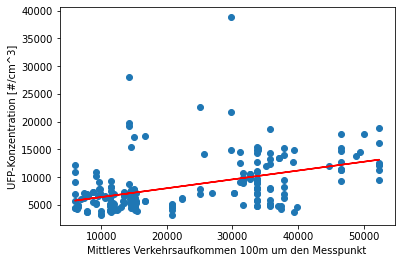

In [25]:
plt.scatter(feature, result)
plt.plot(feature, result_pred, color='red')
plt.xlabel(str('Mittleres Verkehrsaufkommen' + ' 100m um den Messpunkt'))
plt.ylabel('UFP-Konzentration [#/cm^3]')
plt.show()

Die Regressionsgerade beschreibt also die lineare Funktion (`y = a*x + b`), mit der sich die Ultrafeinstaubkonzentration mittels des mittleren Verkehrsaufkommens im Umkreis von 100m um den Messpunkt bis zu einem gewissen Grad vorhersagen lässt.

Der Plot gibt uns eine Ahnung von der Richtung und Stärke des Zusammenhangs. Wir erhalten aber keine Informationen über die Güte des linearen Modells. Darum lassen wir uns die `Funktion` des Modells und den Wert `R²` ausgeben. Letzterer gibt uns ein Maß für die Stärke des Zusammenhangs von X und result.

In [26]:
print('------ Lineare Regression -----')
print('Funktion: y = %.3f * x + %.3f' % (linear_regressor.coef_[0], linear_regressor.intercept_))
print("R² Score: {:.2f}".format(linear_regressor.score(feature, result)))
print("\n")

------ Lineare Regression -----
Funktion: y = 0.159 * x + 4833.015
R² Score: 0.20




Eine universellere (weil für alle Modelle anwendbare) Form Modelle darzustellen, ist Mess- und Modellwerte gegeneinander zu plotten.

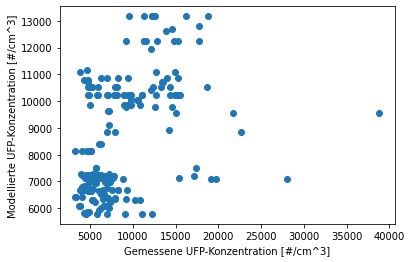

In [27]:
plt.scatter(result, result_pred)
plt.xlabel('Gemessene UFP-Konzentration [#/cm^3]')
plt.ylabel('Modellierte UFP-Konzentration [#/cm^3]')
plt.show()

## Multivariate lineare Regression
Auch komplexere lineare Modelle mit mehreren Prädiktoren lassen sich auf diese Art erstellen. In unserem Fall sind jedoch alle Prädiktoren massiv untereinander korreliert (**Multikolinearität!**) - ein Ausschlusskriterium für lineare Regression. Zu Demonstrationszwecken machen wir es dennoch.

Der einzige Unterschied zur univariaten Regression ist, dass der Funktion ein mehrdimensionales Array übergeben wird.

In [28]:
predictor1 = 'tot_traffic'
predictor2 = 'lkw'
feature = traffic_subset[[predictor1, predictor2]].to_numpy()
result = traffic_subset[['ufp']].to_numpy()
linear_regressor = LinearRegression()
linear_regressor.fit(feature, result)
result_pred = linear_regressor.predict(feature)

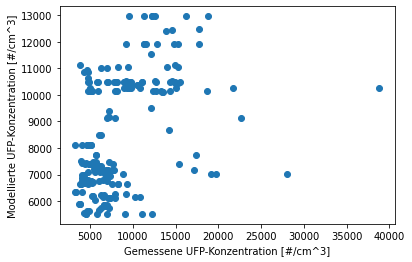

------ Lineare Regression -----
Funktion: y = 0.233 * x1 + -2.756 * x2 + 4272.650
R² Score: 0.20




In [29]:
plt.scatter(result, result_pred)
plt.xlabel('Gemessene UFP-Konzentration [#/cm^3]')
plt.ylabel('Modellierte UFP-Konzentration [#/cm^3]')
plt.show()

print('------ Lineare Regression -----')
print('Funktion: y = %.3f * x1 + %.3f * x2 + %.3f' % (linear_regressor.coef_[0][0], linear_regressor.coef_[0][1], linear_regressor.intercept_))
print("R² Score: {:.2f}".format(linear_regressor.score(feature, result)))
print("\n")

## Multivariate Regression mit ordinalen Prädiktoren            <img align="right" width="400" src="https://miro.medium.com/max/1400/1*O_pTwOZZLYZabRjw3Ga21A.png">
Für die lineare Regression mit ordinalen Prädiktoren, müssen diese **in metrische Daten umgewandelt** werden. Ein bewährtes Verfahren ist das sogenannte **"One-Hot-Encoding"** oder "1-aus-n-Kodierung". Jede Kategorie (hier Straßenklasse) erhält eine eigene Spalte, in der alle Zeilen die mit dieser Kategorie klassifiziert wurden eine `1` und alle anderen eine `0` enthalten.

Um den Einfluss von Multikolinearität zu reduzieren wird außerdem empfohlen alle numerischen Prädiktoren zu standardisieren. `scikit-learn` bietet eine Funktion mit der diese Vorbereitungsschritte auf einmal erledigt werden können. 

In [30]:
t = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['street_class']),
    ('scale', StandardScaler(), ['tot_traffic']),
])

features = t.fit_transform(traffic_subset)
result = traffic_subset['ufp']

print(features[0:20])

[[ 0.          0.          1.          0.          0.         -0.66720008]
 [ 0.          0.          1.          0.          0.         -0.62344622]
 [ 0.          0.          1.          0.          0.         -0.59432675]
 [ 0.          0.          1.          0.          0.         -0.59432675]
 [ 0.          0.          1.          0.          0.         -0.63419802]
 [ 0.          0.          0.          0.          1.         -0.63419802]
 [ 0.          0.          0.          1.          0.         -0.66421347]
 [ 0.          0.          1.          0.          0.         -0.67526394]
 [ 0.          0.          1.          0.          0.         -0.67586126]
 [ 0.          0.          1.          0.          0.         -0.87506829]
 [ 0.          0.          1.          0.          0.         -0.87506829]
 [ 0.          0.          1.          0.          0.         -0.96615996]
 [ 0.          0.          1.          0.          0.         -0.96615996]
 [ 0.          0.        

Jetzt können wir das lineare Regressionsmodell wie gehabt trainieren.

In [31]:
linear_regressor = LinearRegression()
model = linear_regressor.fit(features, result)

result_pred = linear_regressor.predict(features)

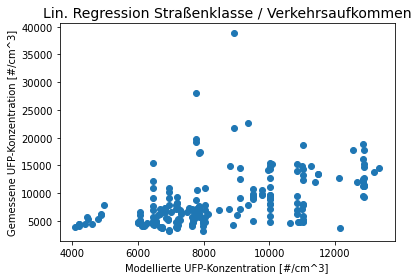

In [32]:
plt.scatter(result_pred, result)
plt.xlabel('Modellierte UFP-Konzentration [#/cm^3]')
plt.ylabel('Gemessene UFP-Konzentration [#/cm^3]')
plt.title('Lin. Regression Straßenklasse / Verkehrsaufkommen', fontsize=14)
plt.show()

Da aus jeder Kategorie (5) durch "One-Hot-Encoding" eine eigene metrische Variable geworden ist, ist unser Modell entsprechnd komplexer. Das Verfahren ist also mit Vorsicht zu genießen.

In [33]:
print('------ Lineare Regression -----')
print('Funktion: y = %.3f * x1 + %.3f * x2 + %.3f + %.3f * x3 + %.3f * x4 + %.3f * x5 + %.3f * x6' %
      (linear_regressor.coef_[0], linear_regressor.coef_[1], linear_regressor.coef_[2],
       linear_regressor.coef_[3], linear_regressor.coef_[4], linear_regressor.coef_[5], linear_regressor.intercept_))
print("R² Score: {:.2f}".format(linear_regressor.score(features, result)))
print("\n")

------ Lineare Regression -----
Funktion: y = -537.854 * x1 + 432.785 * x2 + 1332.552 + 315.812 * x3 + -1543.295 * x4 + 2407.549 * x5 + 7947.386 * x6
R² Score: 0.22




## *Bonuswissen:* Nicht-lineare Regression

Es gibt eine Vielzahl von nicht-linearen Modellen, die jedoch über das übliche Niveau des Geographie-Bachelors hinausgehen. Wer sich jedoch gerne mit einem solchen Verfahren beschäftigen möchte, dem empfehle ich einen Blick auf die sogenannte "Random Forest Regression" zu werfen. Dieser "Wald" besteht aus einer Vielzahl von sogenannten "Decision Trees" und gehört zu den Machine-Learning-Algorithmen. Wen das interessiert, dem kann ich dieses [Youtube-Tutorial](https://www.youtube.com/watch?v=ieF_QjVUNEQ) dazu ans Herz legen.

In Python funktioniert eine Random-Forest-Regression sehr ähnlich zu den bisher behandelten Regressionen.

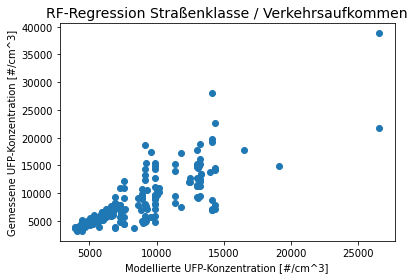

------ Random Forest Regression -----
R² Score: 0.64




In [34]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)
model = rf_reg.fit(features, result)

Y_pred = rf_reg.predict(features)

plt.scatter(Y_pred, result)
plt.xlabel('Modellierte UFP-Konzentration [#/cm^3]')
plt.ylabel('Gemessene UFP-Konzentration [#/cm^3]')
plt.title('RF-Regression Straßenklasse / Verkehrsaufkommen', fontsize=14)
plt.show()

print('------ Random Forest Regression -----')
print("R² Score: {:.2f}".format(rf_reg.score(features, result)))
print("\n")